### Bioneuron Oracle Notebook
#### Peter Duggins
#### April 2017
#### https://github.com/psipeter/bionengo/tree/oracle

This notebook includes methods for specifying weights into an emsemble of biologically realistic neurons such that performs representation and dynamics according to the NEF. These 'bioneurons' are implemented in NEURON based off of a reduced model of a pyramidal neuron by Bahl et al (2012). It begins by defining a bioneuron class that includes the NEURON objects needed to track voltage, spikes, etc, as well as the required nengo methods to run in simulation. It then redefines some classes in the nengo builder to allow construction of bioensembles and transmission of spikes to the bioneurons' synapses. During the build, synapses are created at specified locations on the bioneurons' dendrites, and are assigned a synaptic weight that has been decomposed into encoders and decoders. Whereas previous bioneuron methods trained the enoders, this notebook seeks to distribute encoders randomly in a manner that ensures heterogeneity of bioneuron response curves, then trains decoders using NEF methods such as the least-squares solver or Aaron Voelker's Oracle. It then provides tests for the efficacy of these procedures by find the error in the bioensemble's decoded output for various choices of encoder, decoder, and dynamical system.

For now, I'm working in 1 dimension.

### Install NEURON and other dependencies
change --prefix to another directory. If you're using virtualenv and virtualenvwrapper, this will be your your /HOME/USER/.local/directory

```bash
pip install nengo matplotlib seaborn numpy pandas

wget http://www.neuron.yale.edu/ftp/neuron/versions/v7.4/nrn-7.4.tar.gz
tar xzf nrn-7.4.tar.gz
cd nrn-7.4
./configure --prefix=/home/pduggins/.local --without-iv --with-nrnpython
make
(sudo) make install
cd src/nrnpython
python setup.py install
cd ../../..
```

### Install channel mechanisms for the bahl.hoc NEURON model
To run the NEURON model, bahl.hoc, you must download the .hoc file and .mod files for every ion channel present in the model. These can be found in the oracle branch of my bionengo repo. Be sure to change the path to your .local directory to compile the NEURON channel mechanisms. Once this is done, edit the first line of bahl.hoc to point NEURON towards the location of these compiled channel files.

```bash
git clone -b oracle https://github.com/psipeter/bionengo.git
cd bionengo/NEURON_models/
/home/psipeter/.local/x86_64/bin/nrnivmodl

(bahl.hoc, line 1) nrn_load_dll(path/to/NEURON_models/channels)
```

# Bioneuron Methods
### Define bioneuron class

In [4]:
%matplotlib inline
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import neuron
from nengo.utils.matplotlib import rasterplot

neuron.h.load_file('/home/pduggins/bionengo/NEURON_models/bahl.hoc')

class BahlNeuron(nengo.neurons.NeuronType):
    '''compartmental neuron from Bahl et al 2012'''

    probeable=('spikes','voltage')
    def __init__(self,encoders,gains,syn_locations,weights_bias):
        super(BahlNeuron,self).__init__()
        self.encoders=encoders
        self.gains=gains
        self.syn_locations=syn_locations
        self.weights_bias=weights_bias
        self.inputs={}     #stores the input decoders and calculated connection weights for each connection into bionrn

    def create(self,bio_idx):
        return self.Bahl(bio_idx,self.encoders[bio_idx],self.gains[bio_idx],syn_locations[bio_idx],weights_bias[bio_idx])

    class Bahl():
        def __init__(self,bio_idx,encoder,gain,syn_locations,weights_bias):
            self.bio_idx=bio_idx
            self.encoder=encoder             #single encoder for the bioneuron e_j.
            self.gain=gain                   #single gain for the bioneuron alpha_j
            self.syn_locations=syn_locations #locations of synapses on the dendritic tree l_ij
            self.weights_bias=weights_bias   #values added to w_ij=dot(d_i,e_j) to account for bias
            self.synapses = {}
            self.netcons = {}
            self.cell = neuron.h.Bahl()
        def start_recording(self):
            '''NEURON recording attributes'''
            self.v_record = neuron.h.Vector()
            self.v_record.record(self.cell.soma(0.5)._ref_v)
            self.ap_counter = neuron.h.APCount(self.cell.soma(0.5))
            self.t_record = neuron.h.Vector()
            self.t_record.record(neuron.h._ref_t)
            self.spikes = neuron.h.Vector()
            self.ap_counter.record(neuron.h.ref(self.spikes))
            self.spikes_last=[]
            
    def rates(self, x, gain, bias): #todo: remove this without errors
        return x

    def gain_bias(self, max_rates, intercepts): #todo: remove this without errors
        return np.ones(len(max_rates)),np.ones(len(max_rates))

    def step_math(self,dt,spiked,neurons,voltage,time):
        '''run NEURON forward one nengo timestep. Compare the current and previous spike arrays
        for this bioneuron. If they're different, the neuron has spiked, so communicate this to nengo'''
        t_neuron=time*1000
        neuron.run(t_neuron) 
        new_spiked=[]
        new_voltage=[]
        for nrn in neurons:
            spike_times=np.array(nrn.spikes)
            spike_times_last=np.array(nrn.spikes_last)
            count=len(spike_times)-len(spike_times_last)
            new_spiked.append(count)
            volt=np.array(nrn.v_record)[-1] #fails if neuron.init() not called at right times
            new_voltage.append(volt)
            nrn.spikes_last=spike_times
        spiked[:]=np.array(new_spiked)/dt
        voltage[:]=np.array(new_voltage)

In [5]:
class ExpSyn():
    '''Conductance-based synapses. There are two types, excitatory and inhibitory, with different
    reversal potentials. If the synaptic weight is above zero, initialize an excitatory synapse, 
    else initialize an inhibitory syanpse with the abolute value of the synaptic weight.'''
    def __init__(self, sec, weight, tau, e_exc=0.0, e_inh=-80.0):
        self.type = 'ExpSyn'
        self.tau = tau
        self.e_exc = e_exc
        self.e_inh = e_inh
        self.syn = neuron.h.ExpSyn(sec)
        self.syn.tau=2*1000*self.tau #arbitrary 2x multiply to offset phase shift in bio decode
        self.weight = weight
        if self.weight >= 0.0: self.syn.e = self.e_exc
        else: self.syn.e = self.e_inh
        self.spike_in = neuron.h.NetCon(None, self.syn) #time of spike arrival assigned in nengo step
        self.spike_in.weight[0]=abs(self.weight)

### Nengo Operators and Builders

In [6]:
from nengo.builder import Builder, Operator, Signal
from nengo.dists import get_samples
from nengo.builder.connection import build_decoders
from nengo.builder.connection import BuiltConnection

class SimBahlNeuron(Operator):
    def __init__(self,neurons,n_neurons,output,voltage,states):
        super(SimBahlNeuron,self).__init__()
        self.neurons=neurons
        self.neurons.father_op=self
        self.output=output
        self.voltage=voltage
        self.time=states[0]
        self.reads = [states[0]]
        self.sets=[output,voltage]
        self.updates=[]
        self.incs=[]
        self.label=None
        self.neurons.neurons=[self.neurons.create(i) for i in range(n_neurons)]
        self.inputs=self.neurons.inputs

    def make_step(self,signals,dt,rng):
        output=signals[self.output]
        voltage=signals[self.voltage]
        time=signals[self.time]
        def step_nrn():
            self.neurons.step_math(dt,output,self.neurons.neurons,voltage,time)
        return step_nrn

    def init_connection(self,inpt):
        '''Given a parcicular connection (labeled by inpt=conn.pre),grab the optimal decoders
        calculated for that connection and the number of presynapic neurons in conn.pre.
        At each location in the specified syn_locations list, create a synapse with weight equal to
        w_ij=np.dot(d_i,alpha_j*e_j)+w_bias, where d_i is the optimal presynaptic decoder, e_j is the single
        bioneuron encoder specified in the encoders list, and w_bias is a weight perturbation that emulates
        the bias in a LIF neuron. Once synapses are created and added to the bioneuron attribute .synapses, 
        initialize the NEURON recording variables and call neuron.init()'''
        for bionrn in range(len(self.neurons.neurons)):
            bioneuron=self.neurons.neurons[bionrn]
            input_decoders=self.inputs[inpt]['input_decoders']
            pre_neurons=input_decoders.shape[0]
            bioneuron.synapses[inpt]=np.empty((pre_neurons,n_syn),dtype=object)
            for pre in range(pre_neurons):
                for syn in range(n_syn):
                    decoder=input_decoders[pre]
                    encoder=bioneuron.encoder #assumes single encoder for bioneuron
                    gain=bioneuron.gain
                    w_bias=bioneuron.weights_bias[pre]
                    location=bioneuron.syn_locations[pre][syn]
                    section=bioneuron.cell.apical(location)
                    weight=np.dot(decoder,gain*encoder)+w_bias
                    self.inputs[inpt]['weights'][bionrn,pre,syn]=weight #update weight matrix for this input (debugging)
                    synapse=ExpSyn(section,weight,tau) #create a synapse with the computed weight at this location
                    bioneuron.synapses[inpt][pre][syn]=synapse            
            bioneuron.start_recording() #todo - call elsewhere so it's not redundant
        neuron.init()


In [7]:
class TransmitSpikes(Operator):
    '''Operator to deliver (unweighted) spikes from the presynaptic population into a bioensemble'''
    def __init__(self,ens_pre_label,spikes,bahl_op,states):
        self.ens_pre_label=ens_pre_label
        self.spikes=spikes
        self.bahl_op=bahl_op
        self.neurons=bahl_op.neurons.neurons
        self.time=states[0]
        self.reads=[spikes,states[0]]
        self.updates=[]
        self.sets=[]
        self.incs=[]
    def make_step(self,signals,dt,rng):
        spikes=signals[self.spikes]
        time=signals[self.time]
        def step():
            'event-based method'
            tback=time-dt
            t_neuron=tback*1000
            for n in range(spikes.shape[0]): #for each input neuron
                my_spikes=spikes[n] #actual spikes
                if my_spikes > 0: #if input neuron spiked
                    for nrn in self.neurons: #for each bioneuron
                        for syn in nrn.synapses[self.ens_pre_label][n]: #for each synapse conn. to input
                            syn.spike_in.event(t_neuron) #add a spike at time (ms)
        return step

In [8]:
@Builder.register(BahlNeuron)
def build_bahlneuron(model,neuron_type,ens):
    model.sig[ens]['voltage'] = Signal(np.zeros(ens.ensemble.n_neurons),
                        name='%s.voltage' %ens.ensemble.label)
    op=SimBahlNeuron(neurons=neuron_type,
                     n_neurons=ens.ensemble.n_neurons,
                     output=model.sig[ens]['out'],
                     voltage=model.sig[ens]['voltage'],
                     states=[model.time])
    model.add_op(op)

@Builder.register(nengo.Ensemble)
def build_ensemble(model,ens):
    nengo.builder.ensemble.build_ensemble(model,ens)

@Builder.register(nengo.Connection)
def build_connection(model,conn):
    '''Method to build connections into bioensembles.
    Calculates the optimal decoders for this conneciton as though the presynaptic neuron 
    was connecting to a hypothetical point neuron. These decoders are used to calculate
    the synaptic weights in init_connection().
    Adds a transmit_spike operator for this connection to the model
    '''
    use_nrn = (
        isinstance(conn.post, nengo.Ensemble) and
        isinstance(conn.post.neuron_type, BahlNeuron))
    if use_nrn: #bioneuron connection
        rng = np.random.RandomState(model.seeds[conn])
        model.sig[conn]['in']=model.sig[conn.pre]['out']
        transform = get_samples(conn.transform, conn.size_out, d=conn.size_mid, rng=rng)
        eval_points, weights, solver_info = build_decoders(model, conn, rng, transform)
        op=conn.post.neuron_type.father_op
        op.label=conn.post.label
        op.inputs[conn.pre.label]={'input_decoders':weights.T} #will stop working for bio-bio connections
        op.inputs[conn.pre.label]['weights']=np.zeros((conn.post.n_neurons,conn.pre.n_neurons,n_syn)) #todo: n_syn
        op.init_connection(conn.pre.label)
        model.add_op(
            TransmitSpikes(conn.pre_obj.label,model.sig[conn.pre]['out'],op,states=[model.time]))
        model.params[conn] = BuiltConnection(eval_points=eval_points,
                                             solver_info=solver_info,
                                             transform=transform,
                                             weights=weights)

    else: #normal connection
        return nengo.builder.connection.build_connection(model, conn)

/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/builder/builder.py:232: UserWarning: Type '<class 'nengo.ensemble.Ensemble'>' already has a builder. Overwriting.
  % nengo_class)
/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/builder/builder.py:232: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


### Helper Functions

In [9]:
from nengo.builder.ensemble import get_activities
def decode_bias(bias, activity):
    '''
    From Andreas Stockel 
    Emulate biases by decoding them separately off the LIF population and adding it to the resulting connection weights
    https://github.com/ctn-waterloo/nengo_conductance_synapses/blob/master/ifcondexp.ipynb
    '''
    
    A = activity # Fetch theactivity matrix
    m, n = A.shape  # samples, neurons
    Y = np.tile(bias, (m, 1))  # Desired output function Y -- just repeat "bias" m times
    I = np.eye(n) * ((np.max(A) * 0.1)**2) # Regularisation matrix
    # Calculate the decoders using a least squares estimate
    return (np.dot(np.dot(np.linalg.inv(np.dot(A.T,A)/m + I),A.T),Y).T) / m

def pre_model(pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed):
    '''Build a pre-simulation network to draw encoders, gains, and biases from Nengo,
    scale them, and return a weight matrix that emulates the bias
    (by adding weights to the synaptic weights in init_connection()'''
    
    with nengo.Network(label='preliminary') as pre_model:
#         stim = nengo.Node(lambda t: np.sin(t))
        stim = nengo.Node(lambda t: prime_sinusoids(t,dim,t_final))
        pre=nengo.Ensemble(n_neurons=pre_neurons,dimensions=dim,label='pre',seed=pre_seed)
        lif=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,neuron_type=nengo.LIF(),label='lif',seed=bio_seed)
        post=nengo.Ensemble(n_neurons=pre_neurons,dimensions=dim,seed=9,label='post')
        conn_stim_to_pre=nengo.Connection(stim,pre,synapse=None)
        conn_pre_to_lif=nengo.Connection(pre,lif,synapse=tau)
        conn_lif_to_post=nengo.Connection(lif,post,synapse=tau)
    with nengo.Simulator(pre_model,dt=dt) as pre_sim:
        pre_activities = get_activities(pre_sim.data[pre], pre, pre_sim.data[pre].eval_points)
        encoders=pre_sim.data[lif].encoders
        pre_decoders=pre_sim.data[conn_pre_to_lif].weights.T
        biases=pre_sim.data[lif].bias
        gains=pre_sim.data[lif].gain
        lif_decoders=pre_sim.data[conn_lif_to_post].weights.T
    weights_bias = decode_bias(biases,pre_activities)
    return encoders, gains, weights_bias

def delete_bioneurons(bioensemble):
    '''NEURON garbage collection, so that successive model initializations don't accumulate NEURON objects'''
    for bioneuron in bioensemble.neuron_type.father_op.neurons.neurons:
        del bioneuron

### Stimuli

In [10]:
def prime_sinusoids(t,dim,t_final):
    primes=[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101,
            103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199]
    our_primes=primes[:dim]
    t_per_dim=t_final/dim
    epoch=int(t/t_per_dim)
    reordered_primes=[our_primes[(p + epoch) % len(our_primes)] for p in range(len(our_primes))]
    frequencies=np.pi*np.array(reordered_primes)
    values = np.array([np.sin(w*t) for w in frequencies])
    return values

In [11]:
prime_sinusoids(np.pi/2,3,2*np.pi)

array([-0.43030122,  0.78553281, -0.44280997])

In [12]:
# def constant_tile_dims(t,dt,dim,t_final):
#     assert dim**2 > int(t_final/dt), "must be at least one timestep per dimension"
#     '''construct a (dim x dim) array where each entry is a list with a singnle value for each dimension'''
#     out=[]
#     for d in dims:

### Simulation and Plotting

In [13]:
def simulate(n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,weights_bias,
             pre_seed,bio_seed,decoders_bio=None,plots={'spikes','voltage','decode'}):
    '''
    Simulate a feedforward network [stim]-[LIF]-[BIO], and compare to [stim]-[LIF]-[LIF].
    encoders: encoders for bioneurons calculated for a hypothetical LIF population in pre_model()
    weights_bias: weight additions that emulate the bias for a hypothetical LIF population in pre_model()
    bio_seed: ensemble seed for bioensemble
    pre_seed: ensemble seed for lif emsemble
    decoders_bio: use the output decoders for [BIO]-[probe] from a previous simulation rather than
                    calculating them again using nengo.solver.LstsqL2()
    '''
    with nengo.Network() as model:
        stim = nengo.Node(lambda t: prime_sinusoids(t,dim,t_final))
#         stim = nengo.Node(lambda t: np.sin(2*np.pi*t))
        pre=nengo.Ensemble(n_neurons=100,dimensions=dim,label='pre',seed=pre_seed)
        bio=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,label='bio',seed=bio_seed,
                           neuron_type=BahlNeuron(encoders,gains,syn_locations,weights_bias))
        lif=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,neuron_type=nengo.LIF(),label='lif')
        direct=nengo.Ensemble(n_neurons=1,dimensions=dim,neuron_type=nengo.Direct(),label='direct')

        nengo.Connection(stim,pre,synapse=None)
        nengo.Connection(pre,bio,synapse=tau)
        nengo.Connection(pre,lif,synapse=tau)
        nengo.Connection(stim,direct,synapse=tau)

        probe_stim=nengo.Probe(stim,synapse=None)
        probe_pre=nengo.Probe(pre,synapse=tau)
        probe_lif=nengo.Probe(lif,synapse=tau)
        probe_direct=nengo.Probe(direct,synapse=tau)
        probe_pre_spikes=nengo.Probe(pre.neurons,'spikes')
        probe_bio_spikes=nengo.Probe(bio.neurons,'spikes')
        probe_lif_spikes=nengo.Probe(lif.neurons,'spikes')
        
    with nengo.Simulator(model,dt=dt) as sim:
        sim.run(t_final)
        
    '''make sick plotz'''
    sns.set(context='poster')

    if 'spikes' in plots:
        '''spike raster for PRE, BIO and comparison LIF ensembles'''
        figure, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True)
        rasterplot(sim.trange(),sim.data[probe_pre_spikes],ax=ax1,use_eventplot=True)
        ax1.set(ylabel='pre',yticks=([]))
        rasterplot(sim.trange(),sim.data[probe_bio_spikes],ax=ax2,use_eventplot=True)
        ax2.set(ylabel='bioneuron',yticks=([]))
        rasterplot(sim.trange(),sim.data[probe_lif_spikes],ax=ax3,use_eventplot=True)
        ax3.set(xlabel='time (s)',ylabel='lif') #,yticks=([])

    if 'voltage' in plots:
        '''voltage trace for a specific bioneuron'''
        figure2,ax3=plt.subplots(1,1,sharex=True)
        bio_idx=0
        neuron=bio.neuron_type.father_op.neurons.neurons[bio_idx]
        ax3.plot(dt*np.arange(0,len(np.array(neuron.v_record))),np.array(neuron.v_record))
        ax3.set(xlabel='time (ms)', ylabel='Voltage (mV)')

    if 'decode' in plots:
        '''decoded output of bioensemble'''
        figure3,ax4=plt.subplots(1,1,sharex=True)
        lpf = nengo.Lowpass(tau)
        solver = nengo.solvers.LstsqL2(reg=0.01)
        if decoders_bio==None:
            decoders_bio, info = solver(
                                    lpf.filt(sim.data[probe_bio_spikes], dt=dt),
                                    lpf.filt(sim.data[probe_pre], dt=dt)) #one filter on target
                                    # lpf.filt(lpf.filt(sim.data[probe_pre], dt=P['dt_nengo']), dt=P['dt_nengo']))
        A_bio=lpf.filt(sim.data[probe_bio_spikes], dt=dt)
        xhat_bio=np.dot(A_bio,decoders_bio)
        rmse_bio=np.sqrt(np.average((sim.data[probe_direct]-xhat_bio)**2))
        rmse_lif=np.sqrt(np.average((sim.data[probe_direct]-sim.data[probe_lif])**2))
        ax4.plot(sim.trange(),xhat_bio,label='bio, rmse=%.5f'%rmse_bio)
        ax4.plot(sim.trange(),sim.data[probe_lif],label='lif, rmse=%.5f'%rmse_lif)
        ax4.plot(sim.trange(),sim.data[probe_direct],label='direct')
        ax4.set(ylabel='$\hat{x}(t)$')#,ylim=((ymin,ymax)))
        legend3=ax4.legend() #prop={'size':8}
    
    delete_bioneurons(bio)
    return decoders_bio

# Testing Gains, Biases, and Decoders

In [1]:
pre_neurons=100
n_neurons=50
tau=0.01
dim=1
n_syn=1
dt=0.001
t_final=1.0
pre_seed=3
bio_seed=6

#generate synaptic locations for each neuron
rng=np.random.RandomState(seed=333)
syn_locations=np.array([rng.uniform(0,1,size=(pre_neurons,n_syn)) for n in range(n_neurons)])

NameError: name 'np' is not defined

## No gains, no biases
Simplest setup - single encoder per neuron, one synapse, gains and biases not accounted for, synaptic locations identical for every bioneuron (still a unique location for every synapse on the dendrite)

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:33.                                                 


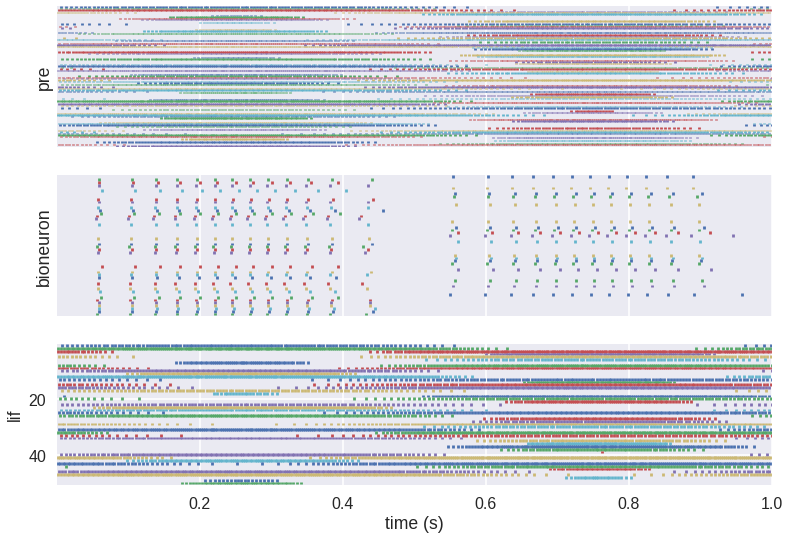

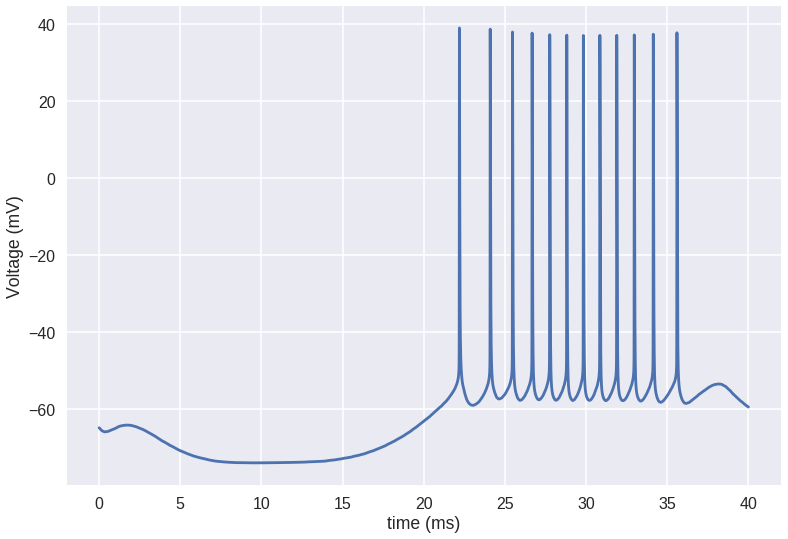

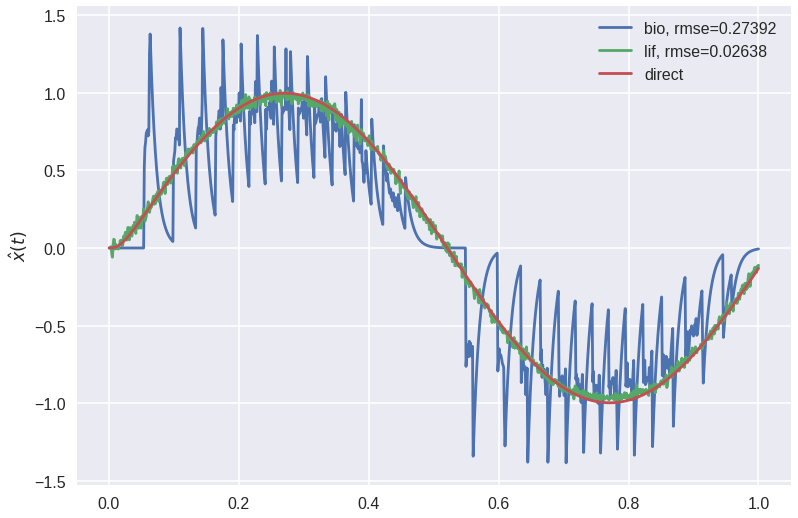

In [34]:
encoders, gains, weights_bias = pre_model(pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed)

gains=np.ones(gains.shape) #ignore gains
weights_bias=np.zeros((weights_bias.shape)) #ignore biases

#save decoders for [BIO]-[probe] for later
decoders_bio_1=simulate(n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,weights_bias,pre_seed,bio_seed)

As shown in the spike plot, there isn't yet much heterogeneity in the bioneuron responses.

## Gains, no biases
Now let's have gains multiply encoders, but keep biases set to zero.

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:32.                                                 


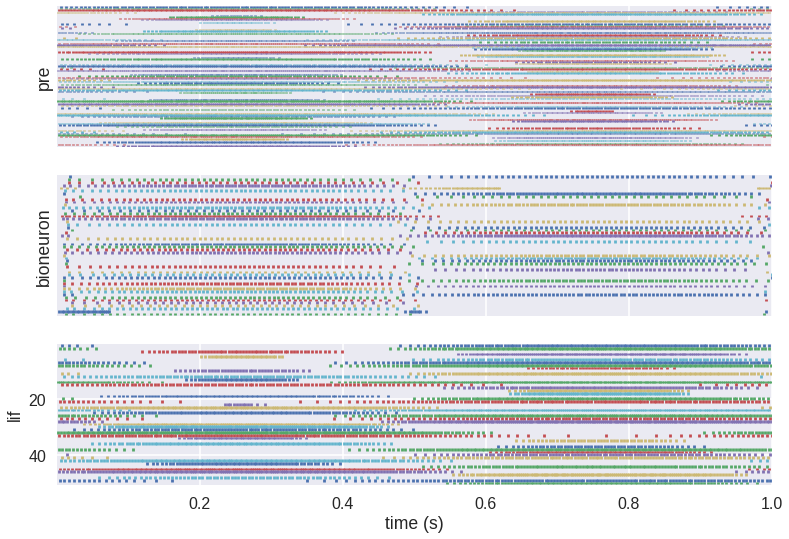

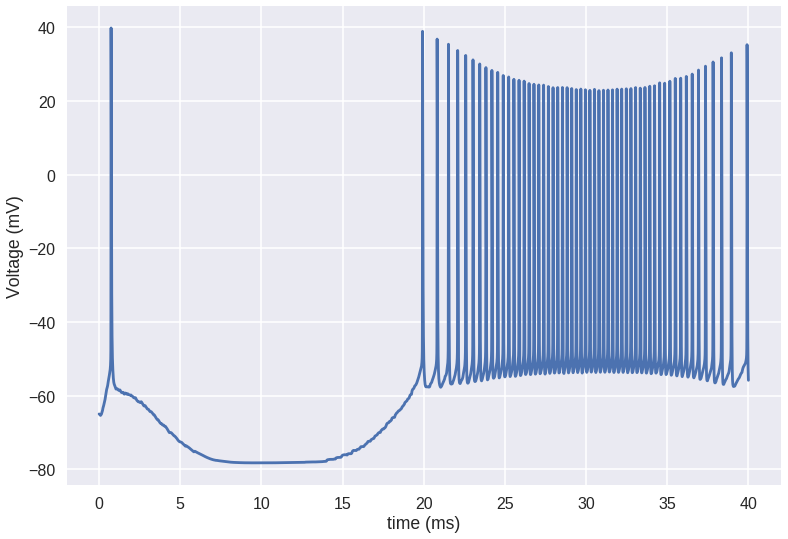

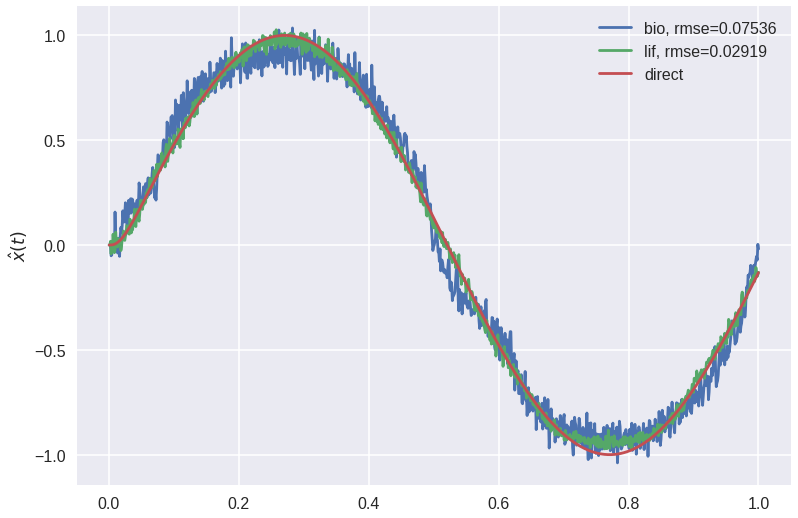

In [35]:
encoders, gains, weights_bias = pre_model(pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed)

weights_bias=np.zeros((weights_bias.shape))

decoders_bio_2=simulate(n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,weights_bias,pre_seed,bio_seed)

That's a much more diverse response, and a good decoding.

## Gains and Biases
Now let's add in the biases by emulating them using Andreas' method.

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:01:03.                                                 


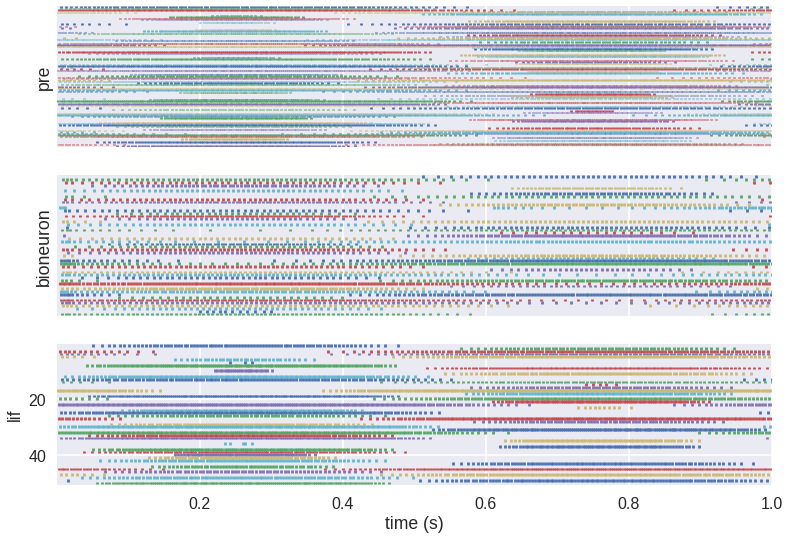

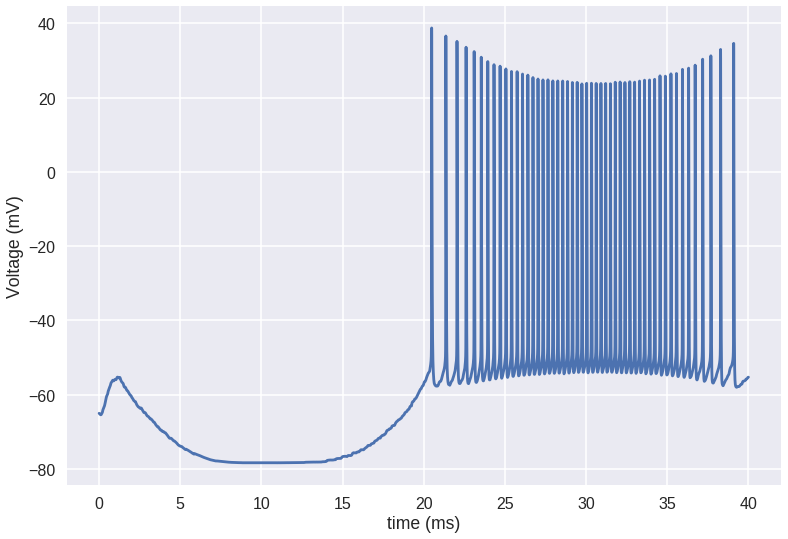

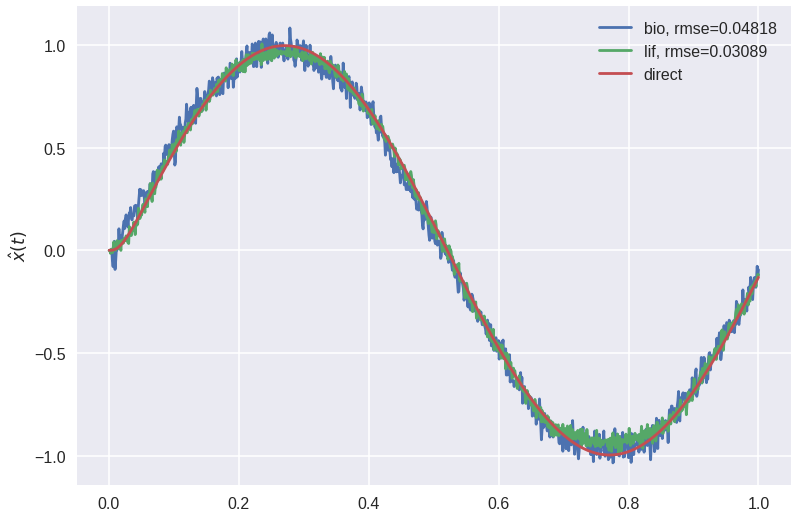

In [36]:
encoders, gains, weights_bias = pre_model(pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed)

decoders_bio_3=simulate(n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,weights_bias,pre_seed,bio_seed)

Looks like adding bias increased the diversity of the bioneuron responses, which further increased the accuracy of the decoding.

## Random decoders

Now let's try and disrupt the decoding by repeating the simulation with a new seed for the pre_LIF population, and hence calculating new [pre]-[lif] weights and weights_bias, but using the same encoders and gains, but using RANDOM decoders. The scale of these decoders will be set by those calculated with the least squares solver in the previous experiment.

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:01:01.                                                 


/home/pduggins/.virtualenvs/oracle/lib/python2.7/site-packages/ipykernel_launcher.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


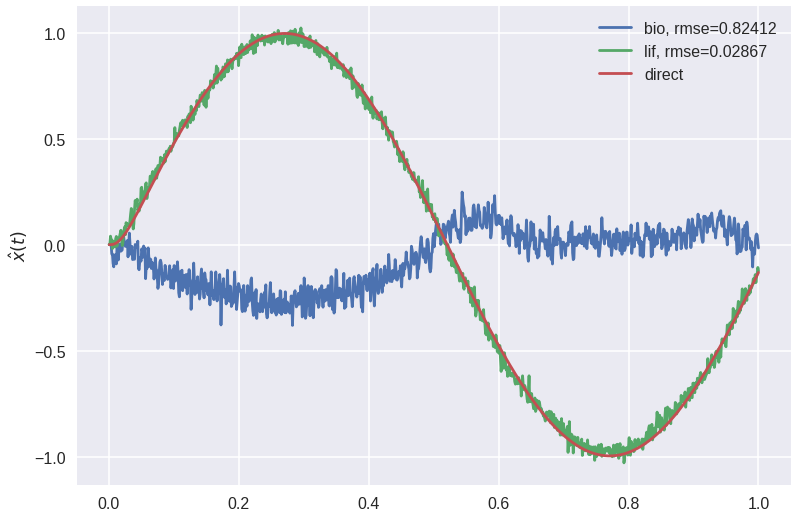

In [37]:
pre_seed=1

encoders, gains, weights_bias = pre_model(pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed)

random_decoders=rng.uniform(np.min(decoders_bio_3),np.max(decoders_bio_3),size=decoders_bio_3.shape)

junk=simulate(n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,weights_bias,
              pre_seed,bio_seed,random_decoders,plots={'decode'})

Random decoders are pretty bad, but since the bioneuron activities are still correlated with the sinusoidal signal, the decoded output still has a sinusoidal shape.

## Previously computed decoders
Now let's try using the [bio]-[probe] decoders calculated in the "Gains and Biases" experiment

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:01:35.                                                 


/home/pduggins/.virtualenvs/oracle/lib/python2.7/site-packages/ipykernel_launcher.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


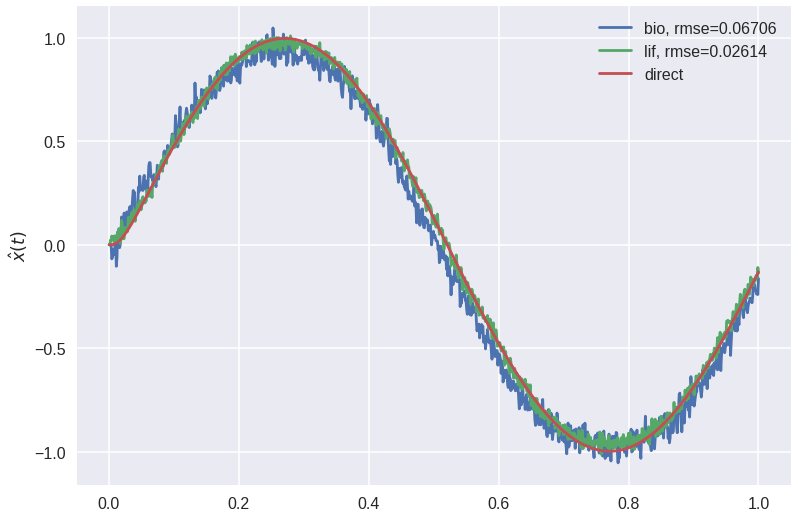

In [38]:
encoders, gains, weights_bias = pre_model(pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed)

decoders_bio_5=simulate(n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,weights_bias,
                            pre_seed,bio_seed,decoders_bio_3,plots={'decode'})

Very accurate decoding! This is promising evidence for the idea that the bioneuron responses might be identical for similar state-space inputs, even if the presynaptic spike trains are different.

As a quick check, use a new weight_bias to make sure that decode_bias() isn't abusing its knowledge of pre_activity. 

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:30.                                                 


/home/pduggins/.virtualenvs/oracle/lib/python2.7/site-packages/ipykernel_launcher.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


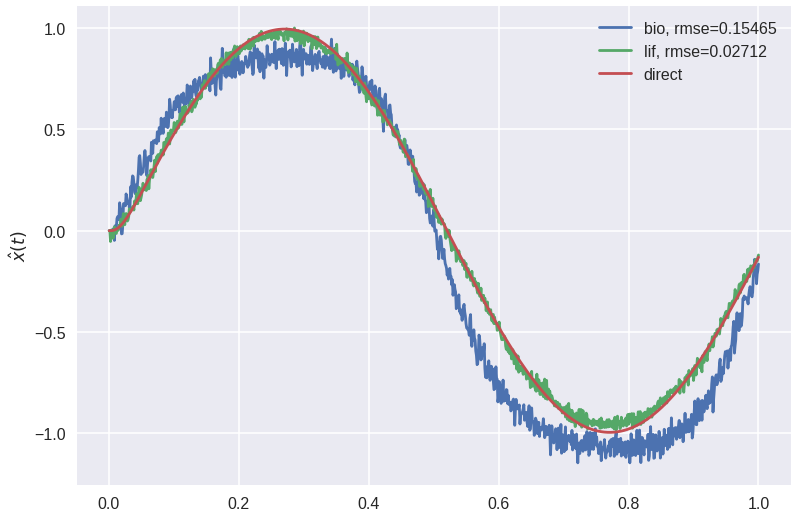

In [39]:
pre_seed=2
encoders, gains, weights_bias = pre_model(pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed)

pre_seed=1
decoders_bio_5=simulate(n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,weights_bias,
                        pre_seed,bio_seed,decoders_bio_3,plots={'decode'})

I think this just demonstrates that if you try to emulate bias by calculating weights_bias off of a specific pre_LIF ensemble, then at test-time you use a different pre_LIF ensemble but add weights_bias to the computed weights nonetheless, the method doesn't work. What's strange is that the method does worse than the "gains, no bias" experiment, so adding the wrong bias systematically degrades the decoding (when using old decoders).

## Multiple dimensions

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:01:00.                                                 


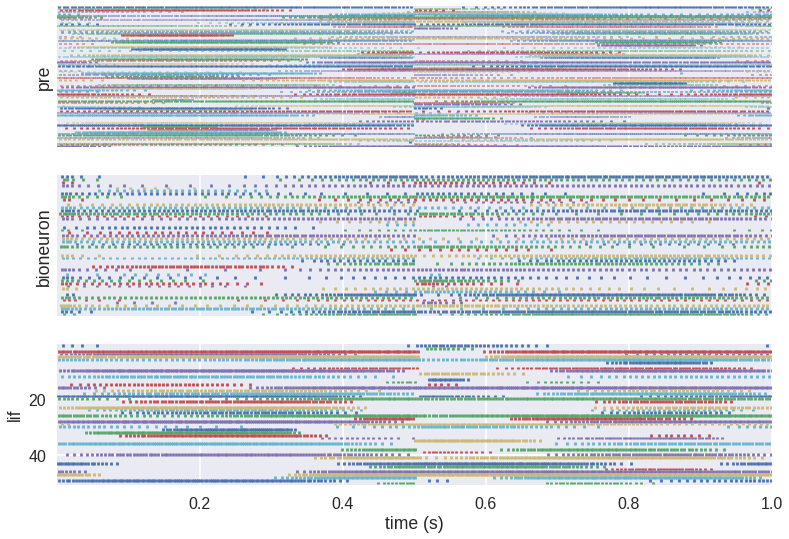

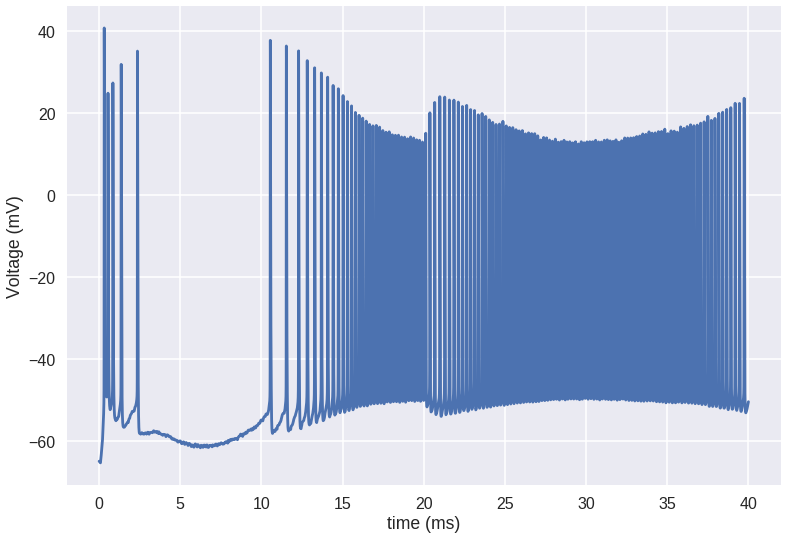

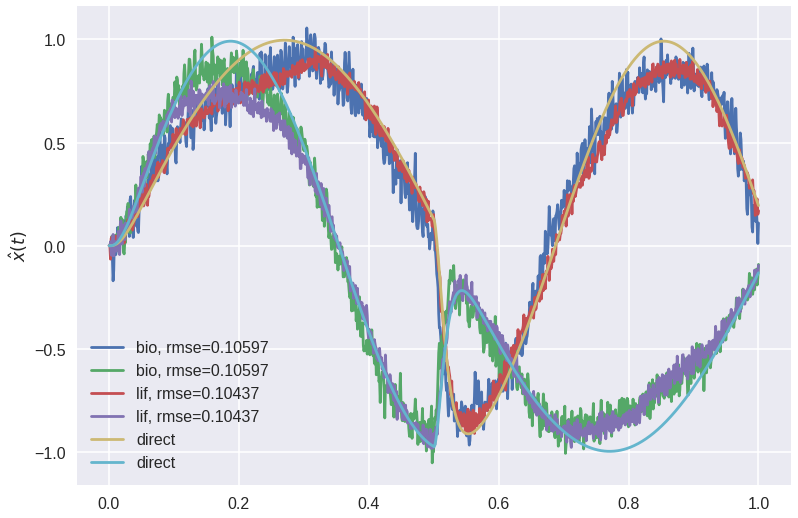

In [40]:
pre_seed=3
bio_seed=6
dim=2
t_final=1.0

encoders, gains, weights_bias = pre_model(pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed)
junk=simulate(n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,weights_bias,pre_seed,bio_seed)

# Tuning Curve Unit Test

In [132]:
def tuning_curve_sinusoid_delta_rates(n_neurons,tau,dim,n_syn,dt,
                                        encoders,gains,syn_locations,weights_bias,
                                        pre_seed,bio_seed,n_eval_points,
                                        decoders_bio=None,plots={'tuning_bio'}):

    with nengo.Network() as model:
        stim = nengo.Node(lambda t: prime_sinusoids(t,dim,t_final))
        pre=nengo.Ensemble(n_neurons=100,dimensions=dim,label='pre',seed=pre_seed)
        bio=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,label='bio',seed=bio_seed,
                           neuron_type=BahlNeuron(encoders,gains,syn_locations,weights_bias))
        lif=nengo.Ensemble(n_neurons=n_neurons,dimensions=dim,neuron_type=nengo.LIF(),label='lif')
        direct=nengo.Ensemble(n_neurons=1,dimensions=dim,neuron_type=nengo.Direct(),label='direct')

        nengo.Connection(stim,pre,synapse=None)
        nengo.Connection(pre,bio,synapse=tau)
        nengo.Connection(pre,lif,synapse=tau)
        nengo.Connection(stim,direct,synapse=tau)

        probe_stim=nengo.Probe(stim,synapse=None)
        probe_pre=nengo.Probe(pre,synapse=tau)
        probe_lif=nengo.Probe(lif,synapse=tau)
        probe_direct=nengo.Probe(direct,synapse=tau)
        probe_pre_spikes=nengo.Probe(pre.neurons,'spikes')
        probe_bio_spikes=nengo.Probe(bio.neurons,'spikes')
        probe_lif_spikes=nengo.Probe(lif.neurons,'spikes')
        
    with nengo.Simulator(model,dt=dt) as sim:
        sim.run(t_final)

    if 'tuning_bio' in plots or 'tuning_lif' in plots:
        columns=('t_idx','x_dot_e','x_dot_e_bin','t','neuron','rate_bio','rate_lif')
        for d in range(dim):
            columns=columns+('x_%s'%d,)
        df=pd.DataFrame(columns=columns,index=np.arange(0,n_neurons*(sim.trange().shape[0]-1)))
    
    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return array[idx]
        
    lpf=nengo.Lowpass(tau)
    delta_rates=np.zeros((n_neurons))
    print 'Constructing Pandas Dataframe...'
    j=0
    for bionrn in range(n_neurons):
        rates_bio=lpf.filt(sim.data[probe_bio_spikes][:,bionrn],dt=dt)
        rates_lif=lpf.filt(sim.data[probe_lif_spikes][:,bionrn],dt=dt)
        x_dot_e=np.dot(sim.data[probe_pre],encoders[bionrn])
        delta_rates[bionrn]=np.max(rates_bio)-np.min(rates_bio)
        x_dot_e_vals=np.linspace(np.min(x_dot_e),np.max(x_dot_e),num=n_eval_points)

        for t in np.arange(1,sim.trange().shape[0]):
            x_dot_e_bin=np.round(find_nearest(x_dot_e_vals,x_dot_e[t]),decimals=2)
            info=[int(t),x_dot_e[t],x_dot_e_bin,t*dt,str(bionrn),rates_bio[t],rates_lif[t]]
            for d in range(dim):
                info.append(sim.data[probe_pre][t,d])
            df.loc[j]=info
            j+=1

    if 'stim' in plots:
        sns.set(context='poster')
        figure3,ax3=plt.subplots(1,1)
        ax3.plot(sim.trange(),sim.data[probe_stim])
        ax3.set(ylabel='stim')
    if 'spikes' in plots:
        figure2,ax2=plt.subplots(1,1)
        rasterplot(sim.trange(),sim.data[probe_bio_spikes],ax=ax2,use_eventplot=True)
        ax2.set(ylabel='bioneuron',yticks=([]))
    if '2d_heatmap' in plots:
        assert dim==2
        fig_heatmap,ax_heatmap=plt.subplots(1,1)
#         sns.jointplot('x_0','x_1',data=df,kind='kde',ax=ax_heatmap)
        heatmap=df.query('neuron=="1"').pivot('x_0','x_1','rate_bio')
        sns.heatmap(heatmap,ax=ax_heatmap)
        ax_heatmap.set(xlabel='$x_0$',ylabel='$x_1$',title='rates_bio')
    if 'tuning_bio' in plots:
        figure1,ax1=plt.subplots(1,1)
        sns.boxplot(x='x_dot_e_bin',y='rate_bio',hue='neuron',data=df)
#         sns.tsplot(time="t",value="rate_bio",condition='neuron',data=df,ax=ax1) #todo: fix for readable tuning curves
        ax1.set(xlabel='$x . e_j$',ylabel='BIO firing rate (hz)')
    if 'tuning_lif' in plots:
        figure4,ax4=plt.subplots(1,1)
        sns.boxplot(x='x_dot_e_bin',y='rate_lif',hue='neuron',data=df)
#         sns.tsplot(time="x_dot_e_bin",value="rate_lif",unit='t',condition='neuron',data=df,ax=ax4) #todo: fix for readable tuning curves
        ax4.set(xlabel='$x . e_j$',ylabel='LIF firing rate (hz)')
                
    return np.array(delta_rates),df

While there are bioneurons whose min and max firing rate differ by less than the delta_rates_threshold, keep choosing new encoders and weights_bias for those.

Min and max rate are measured in response to an input signal that is either sinusoidal (each dimension has a sinusoid with prime frequencies, see prime_sinusoids() method), or step inputs ranging from x_min to x_max (TODO: multiple dimensions), 

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Constructing Pandas Dataframe...
[ 240.96165178    0.          126.83945375] 1
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Constructing Pandas Dataframe...
[ 240.96165178  147.38891427  126.83945375] 0
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


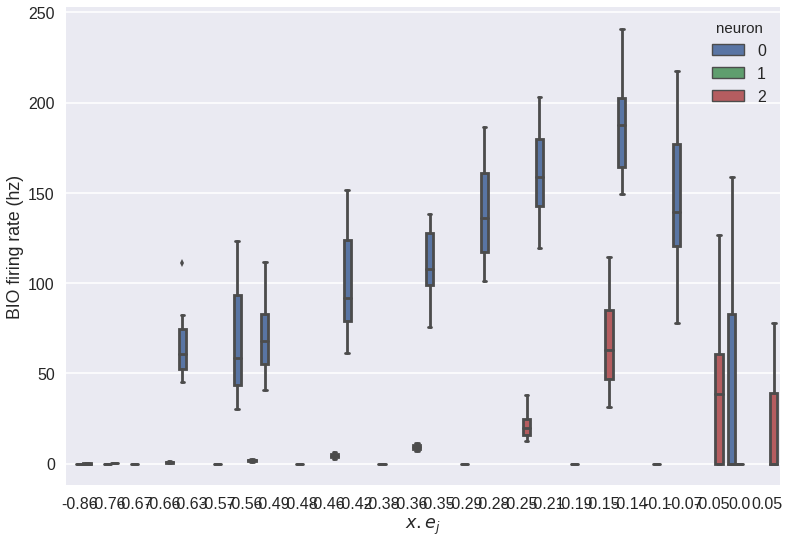

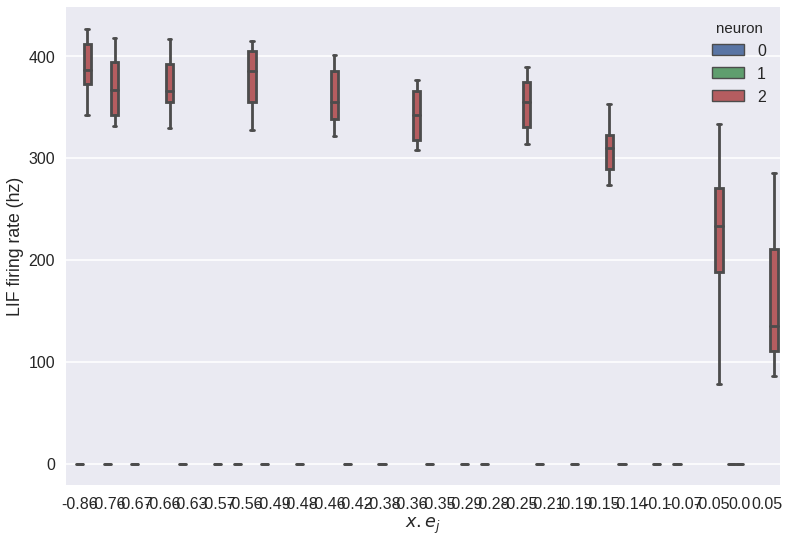

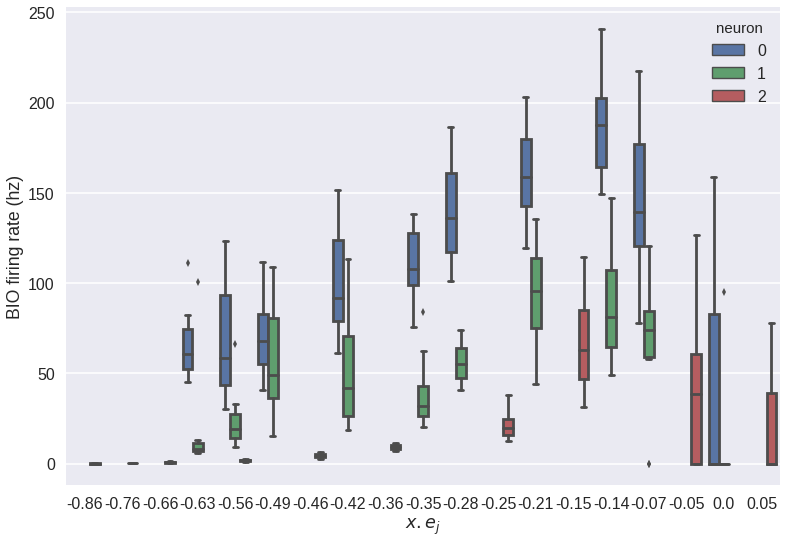

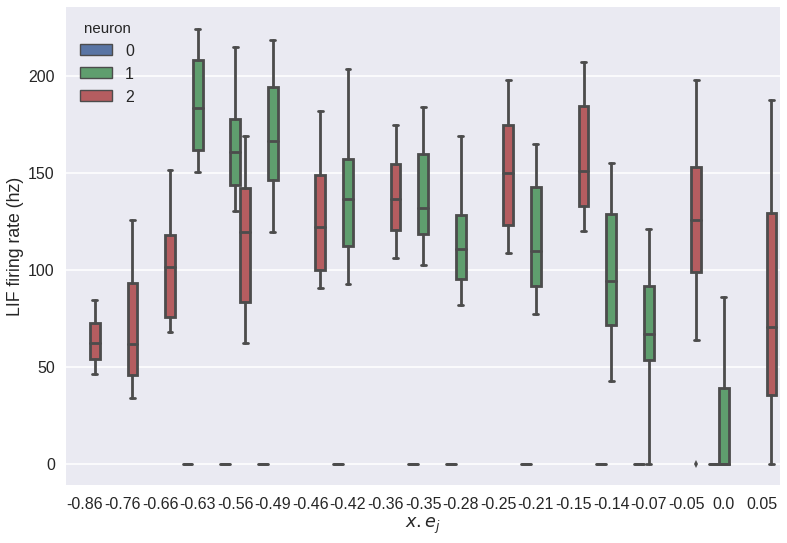

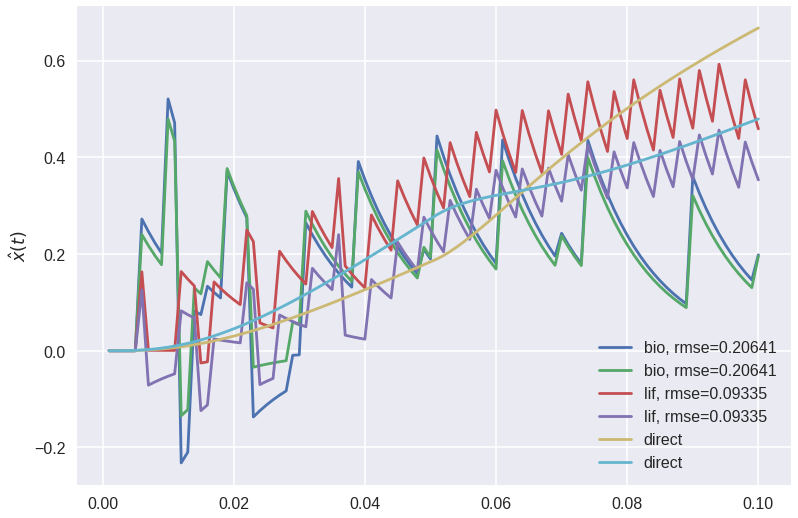

In [144]:
pre_neurons=100
n_neurons=3
tau=0.01
dim=2
n_syn=1
dt=0.001
t_final=0.1
pre_seed=3
bio_seed=6
delta_rates_threshold=5
rng=np.random.RandomState(seed=333)
syn_locations=np.array([rng.uniform(0,1,size=(pre_neurons,n_syn)) for n in range(n_neurons)])

'''For 1D step inputs'''
dx=0.2
t_per_x=0.5
x_vals=np.arange(-1,1,dx)
'''For prime sinusiods input'''
n_eval_points=10

#first guess for bioneuron parameters
encoders, gains, weights_bias = pre_model(pre_neurons,n_neurons,tau,dim,n_syn,dt,t_final,pre_seed,bio_seed)

idx_unresponsive=np.arange(0,n_neurons) #array of bio_idx that don't cross rate threshold
while idx_unresponsive.shape[0] != 0:
    delta_rates,df=tuning_curve_sinusoid_delta_rates(
                                        n_neurons,tau,dim,n_syn,dt,
                                        encoders,gains,syn_locations,weights_bias,
                                        pre_seed,bio_seed,n_eval_points,
                                        decoders_bio=None,plots={'tuning_bio','tuning_lif'})
    idx_unresponsive=np.where(delta_rates<delta_rates_threshold)[0]
    print delta_rates, idx_unresponsive.shape[0]
    for n in idx_unresponsive:
        encoders[n], gains[n], weights_bias[n] = pre_model(
                    pre_neurons,1,tau,dim,n_syn,dt,t_final,rng.randint(336699),bio_seed)

decoders_bio_6=simulate(n_neurons,tau,dim,n_syn,dt,t_final,encoders,gains,weights_bias,
                        pre_seed,bio_seed,plots={'decode'})

### I can't figure out how to plot the tuning curves using sns.tsplot(), or even a time series using this function

t_idx              1
x_dot_e            0
x_dot_e_bin        0
t              0.001
neuron             0
rate_bio           0
rate_lif           0
x_0                0
x_1                0
Name: 0, dtype: object
(<type 'numpy.float64'>, <type 'numpy.float64'>, <type 'numpy.float64'>, <type 'str'>, <type 'numpy.float64'>, <type 'numpy.float64'>, <type 'numpy.float64'>, <type 'numpy.float64'>)


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

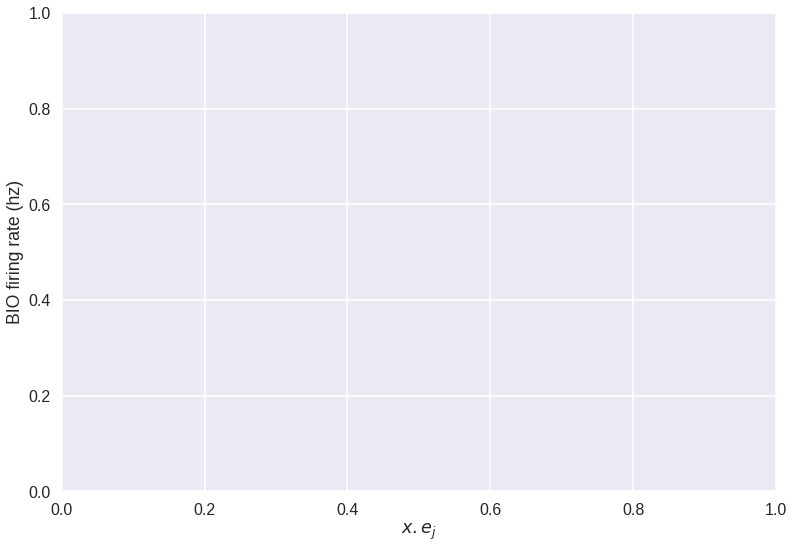

In [146]:
print df.loc[0]

print (type(df.loc[0]['x_dot_e']),
type(df.loc[0]['x_dot_e_bin']),
type(df.loc[0]['t']),
type(df.loc[0]['neuron']),
type(df.loc[0]['rate_bio']),
type(df.loc[0]['rate_lif']),
type(df.loc[0]['x_0']),
type(df.loc[0]['x_1']))

figure1,ax1=plt.subplots(1,1)
'''works, but it's ugly'''
# sns.boxplot(x='x_dot_e_bin',y='rate_bio',hue='neuron',data=df
ax1.set(xlabel='$x . e_j$',ylabel='BIO firing rate (hz)')

'''Throws unsupported operand type(s) for +: 'NoneType' and 'NoneType' '''
sns.tsplot(time="t",value="rate_bio",condition='neuron',data=df,ax=ax1) #how tsplot should be used
# sns.tsplot(time="x_dot_e_bin",value="rate_bio",unit='t_idx',condition='neuron',data=df,ax=ax1)  #how I want to plot tuning curves

# heatmap=df.query('neuron=="1"')
# heatmap=heatmap.pivot('x_0','x_1','rate_bio')
# sns.heatmap(heatmap,ax=ax_heatmap)

In [ ]:
gammas = sns.load_dataset("gammas")

gammas.loc[0]

print (type(gammas.loc[0]['timepoint']),
type(gammas.loc[0]['ROI']),
type(gammas.loc[0]['subject']),
type(gammas.loc[0]['BOLD signal']))

figure1,ax1=plt.subplots(1,1)
# sns.boxplot(x='x_dot_e_bin',y='rate_bio',hue='neuron',data=df)
sns.tsplot(time="timepoint",value="BOLD signal",unit='subject',condition='ROI',data=gammas,ax=ax1)
ax1.set(xlabel='$t$',ylabel='BOLD')